# Baseline Random Forest Training on CRPWarner Dataset

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import json
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier

## Const

In [3]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [4]:
with open(os.path.join(DATA_PATH, 'feature_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json')) as f:
    labels = json.load(f)

In [5]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

## Traditional Machine Learning Models

In [6]:
models = {
    "Logistic Regression": MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    "Random Forest": MultiOutputClassifier(RandomForestClassifier()),
    "Gradient Boosting": MultiOutputClassifier(GradientBoostingClassifier()),
    "AdaBoost": MultiOutputClassifier(AdaBoostClassifier()),
    "SVM (Linear)": MultiOutputClassifier(SVC(kernel="linear")),
    "KNN": MultiOutputClassifier(KNeighborsClassifier()),
    "Naive Bayes": MultiOutputClassifier(GaussianNB()),
    "MLP Classifier": MultiOutputClassifier(MLPClassifier(max_iter=300)),
    "XGBoost": MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    "LightGBM": MultiOutputClassifier(LGBMClassifier()),
    "DecisionTree": MultiOutputClassifier(DecisionTreeClassifier())
}

In [7]:
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),  # change to 'macro' if multi-class
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1-Score": f1_score(y_test, y_pred, average="macro"),
        "Training Time": round(end - start, 3)
    })

[LightGBM] [Info] Number of positive: 14, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254545 -> initscore=-1.074515
[LightGBM] [Info] Start training from score -1.074515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### Result

In [8]:
df = pd.DataFrame(results)
df.sort_values(by="F1-Score", ascending=False, inplace=True)
df

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Time
3,AdaBoost,0.428571,0.750000,0.444444,0.535294,0.344
2,Gradient Boosting,0.357143,0.555556,0.388889,0.438889,0.516
8,XGBoost,0.428571,0.738095,0.351852,0.436905,0.815
5,KNN,0.214286,0.462121,0.425926,0.433333,0.009
9,LightGBM,0.428571,0.722222,0.314815,0.406349,0.092
10,DecisionTree,0.285714,0.555556,0.333333,0.388889,0.026
0,Logistic Regression,0.285714,0.500000,0.277778,0.353846,0.495
4,SVM (Linear),0.285714,0.500000,0.277778,0.353846,0.022
6,Naive Bayes,0.285714,0.444444,0.203704,0.279202,0.013
1,Random Forest,0.357143,0.555556,0.203704,0.273016,0.412


### Tuning

In [9]:
# 1. Optuna objective with AdaBoost inside MultiOutputClassifier
def objective(trial):
    model = MultiOutputClassifier(AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.0000001, 1.0),
        random_state=42
    ))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average="macro", zero_division=0)

# 2. Optimize AdaBoost
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 3. Build base classifiers
model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Tuned AdaBoostClassifier (MultiOutput):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))


[I 2025-07-11 12:33:56,403] A new study created in memory with name: no-name-1e20b3f3-d21b-4950-8b77-3fe33fe9717d
[I 2025-07-11 12:33:56,753] Trial 0 finished with value: 0.5407407407407407 and parameters: {'n_estimators': 29, 'learning_rate': 0.8487428417692037}. Best is trial 0 with value: 0.5407407407407407.
[I 2025-07-11 12:33:58,282] Trial 1 finished with value: 0.4246498599439776 and parameters: {'n_estimators': 118, 'learning_rate': 0.7491792413534307}. Best is trial 0 with value: 0.5407407407407407.
[I 2025-07-11 12:33:59,692] Trial 2 finished with value: 0.4878306878306879 and parameters: {'n_estimators': 144, 'learning_rate': 0.5302842729112323}. Best is trial 0 with value: 0.5407407407407407.
[I 2025-07-11 12:34:06,225] Trial 3 finished with value: 0.4878306878306879 and parameters: {'n_estimators': 877, 'learning_rate': 0.8530638625327452}. Best is trial 0 with value: 0.5407407407407407.
[I 2025-07-11 12:34:10,839] Trial 4 finished with value: 0.4878306878306879 and paramet

Tuned AdaBoostClassifier (MultiOutput):
Accuracy: 0.35714285714285715
Precision: 0.6833333333333332
Recall: 0.5740740740740741
F1 Score: 0.5981620718462823


In [10]:
joblib.dump(model, os.path.join(MODEL_PATH, f'best_ada_model_on_crpwarner.pkl'))

['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_ada_model_on_crpwarner.pkl']

### K-Fold (K=3)

In [11]:
NUM_FOLDS = 3
results = []
best_model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
best_f1 = 0
best_fold = 0

In [12]:
for fold in range(NUM_FOLDS):
    print(f"=========== Fold-{fold} ===========")
    train_path = os.path.join(DATA_PATH, f'train_fold_{fold}.csv')
    val_path = os.path.join(DATA_PATH, f'val_fold_{fold}.csv')

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)

    X_train = train_df[feature_list]
    y_train = train_df[labels]

    X_val = val_df[feature_list]
    y_val = val_df[labels]

    # Train model
    model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    results.append({'fold': fold, 'accuracy': acc, 'report': report})
    print(f"Accuracy: {acc}")
    print("Precision:", precision_score(y_val, y_pred, average="macro", zero_division=0))
    print("Recall:", recall_score(y_val, y_pred, average="macro", zero_division=0))
    print("F1 Score:", f1)

    if best_f1 < f1:
        best_model = model
        best_fold = fold
## Step 6: Average Performance Summary
print("\n===== Overall Summary =====")
avg_acc = sum([r['accuracy'] for r in results]) / NUM_FOLDS
print(f"Average Accuracy: {avg_acc:.4f}")

# Save model
joblib.dump(best_model, os.path.join(MODEL_PATH, f'best_ada_model_on_crpwarner_from_fold{best_fold}.pkl'))

=========== Fold-0 ===========
Accuracy: 0.4782608695652174
Precision: 0.38484848484848483
Recall: 0.6222222222222222
F1 Score: 0.47385620915032683
=========== Fold-1 ===========
Accuracy: 0.391304347826087
Precision: 0.4166666666666667
Recall: 0.47301587301587306
F1 Score: 0.42157842157842157
=========== Fold-2 ===========
Accuracy: 0.6086956521739131
Precision: 0.8333333333333334
Recall: 0.42063492063492064
F1 Score: 0.5555555555555555

===== Overall Summary =====
Average Accuracy: 0.4928


['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_ada_model_on_crpwarner_from_fold2.pkl']

## CNN

### Structure

In [13]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

opcode_dim = len(feature_list)

def MLClassifier():
    return Sequential([
        Dense(512, input_dim=opcode_dim, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

model = MLClassifier()
model.compile(
    loss='binary_crossentropy',  # important for multi-label!
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', 'AUC']
)


2025-07-11 12:37:48.305482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_file = os.path.join(MODEL_PATH, "cnn_best_model_on_crpwarner.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 0.5334 - accuracy: 0.5435 - loss: 1.5710

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - AUC: 0.5334 - accuracy: 0.5435 - loss: 1.5710 - val_AUC: 0.2465 - val_accuracy: 0.2143 - val_loss: 3.8858 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.6503 - accuracy: 0.5000 - loss: 1.4959

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - AUC: 0.6503 - accuracy: 0.5000 - loss: 1.4959 - val_AUC: 0.2465 - val_accuracy: 0.1429 - val_loss: 3.0485 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.5225 - accuracy: 0.3261 - loss: 1.5051

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - AUC: 0.5225 - accuracy: 0.3261 - loss: 1.5051 - val_AUC: 0.2662 - val_accuracy: 0.0714 - val_loss: 2.7608 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.7433 - accuracy: 0.5000 - loss: 1.3883

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - AUC: 0.7433 - accuracy: 0.5000 - loss: 1.3883 - val_AUC: 0.2928 - val_accuracy: 0.1429 - val_loss: 2.7344 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.7941 - accuracy: 0.5217 - loss: 1.3426

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - AUC: 0.7941 - accuracy: 0.5217 - loss: 1.3426 - val_AUC: 0.3461 - val_accuracy: 0.1429 - val_loss: 2.5860 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.7868 - accuracy: 0.5870 - loss: 1.3410

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - AUC: 0.7868 - accuracy: 0.5870 - loss: 1.3410 - val_AUC: 0.3727 - val_accuracy: 0.1429 - val_loss: 2.4843 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.7392 - accuracy: 0.5000 - loss: 1.3466

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - AUC: 0.7392 - accuracy: 0.5000 - loss: 1.3466 - val_AUC: 0.3808 - val_accuracy: 0.1429 - val_loss: 2.4821 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.8070 - accuracy: 0.5217 - loss: 1.2852

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - AUC: 0.8070 - accuracy: 0.5217 - loss: 1.2852 - val_AUC: 0.3981 - val_accuracy: 0.1429 - val_loss: 2.4395 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.7700 - accuracy: 0.4783 - loss: 1.3359

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - AUC: 0.7700 - accuracy: 0.4783 - loss: 1.3359 - val_AUC: 0.4086 - val_accuracy: 0.1429 - val_loss: 2.3857 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8323 - accuracy: 0.6304 - loss: 1.2488

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - AUC: 0.8323 - accuracy: 0.6304 - loss: 1.2488 - val_AUC: 0.4016 - val_accuracy: 0.1429 - val_loss: 2.3439 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.7865 - accuracy: 0.4565 - loss: 1.2680

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - AUC: 0.7865 - accuracy: 0.4565 - loss: 1.2680 - val_AUC: 0.4051 - val_accuracy: 0.1429 - val_loss: 2.2689 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.8547 - accuracy: 0.4783 - loss: 1.2071

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - AUC: 0.8547 - accuracy: 0.4783 - loss: 1.2071 - val_AUC: 0.4063 - val_accuracy: 0.1429 - val_loss: 2.2309 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.8731 - accuracy: 0.5000 - loss: 1.1731

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - AUC: 0.8731 - accuracy: 0.5000 - loss: 1.1731 - val_AUC: 0.4051 - val_accuracy: 0.1429 - val_loss: 2.1755 - learning_rate: 0.0010
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.8429 - accuracy: 0.4783 - loss: 1.1868

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - AUC: 0.8429 - accuracy: 0.4783 - loss: 1.1868 - val_AUC: 0.3935 - val_accuracy: 0.1429 - val_loss: 2.1192 - learning_rate: 0.0010
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8581 - accuracy: 0.5000 - loss: 1.1729

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - AUC: 0.8581 - accuracy: 0.5000 - loss: 1.1729 - val_AUC: 0.3669 - val_accuracy: 0.1429 - val_loss: 2.0696 - learning_rate: 0.0010
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.8541 - accuracy: 0.4348 - loss: 1.1537

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - AUC: 0.8541 - accuracy: 0.4348 - loss: 1.1537 - val_AUC: 0.3681 - val_accuracy: 0.0714 - val_loss: 2.0225 - learning_rate: 0.0010
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.8405 - accuracy: 0.4783 - loss: 1.1568

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - AUC: 0.8405 - accuracy: 0.4783 - loss: 1.1568 - val_AUC: 0.3611 - val_accuracy: 0.0714 - val_loss: 1.9781 - learning_rate: 0.0010
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUC: 0.8956 - accuracy: 0.5217 - loss: 1.1027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - AUC: 0.8956 - accuracy: 0.5217 - loss: 1.1027 - val_AUC: 0.3576 - val_accuracy: 0.0714 - val_loss: 1.9371 - learning_rate: 0.0010
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.8800 - accuracy: 0.6087 - loss: 1.1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - AUC: 0.8800 - accuracy: 0.6087 - loss: 1.1000 - val_AUC: 0.3611 - val_accuracy: 0.0714 - val_loss: 1.9001 - learning_rate: 0.0010
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8781 - accuracy: 0.5000 - loss: 1.1046

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - AUC: 0.8781 - accuracy: 0.5000 - loss: 1.1046 - val_AUC: 0.3553 - val_accuracy: 0.0714 - val_loss: 1.8729 - learning_rate: 0.0010
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.8819 - accuracy: 0.5652 - loss: 1.0897

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - AUC: 0.8819 - accuracy: 0.5652 - loss: 1.0897 - val_AUC: 0.3461 - val_accuracy: 0.0714 - val_loss: 1.8544 - learning_rate: 0.0010
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.8960 - accuracy: 0.5217 - loss: 1.0618

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - AUC: 0.8960 - accuracy: 0.5217 - loss: 1.0618 - val_AUC: 0.3553 - val_accuracy: 0.0714 - val_loss: 1.8386 - learning_rate: 0.0010
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.9128 - accuracy: 0.5435 - loss: 1.0430

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - AUC: 0.9128 - accuracy: 0.5435 - loss: 1.0430 - val_AUC: 0.3576 - val_accuracy: 0.0714 - val_loss: 1.8307 - learning_rate: 0.0010
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.8912 - accuracy: 0.5652 - loss: 1.0576

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - AUC: 0.8912 - accuracy: 0.5652 - loss: 1.0576 - val_AUC: 0.3576 - val_accuracy: 0.0714 - val_loss: 1.8188 - learning_rate: 0.0010
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.8992 - accuracy: 0.5000 - loss: 1.0479

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - AUC: 0.8992 - accuracy: 0.5000 - loss: 1.0479 - val_AUC: 0.3495 - val_accuracy: 0.0714 - val_loss: 1.8085 - learning_rate: 0.0010
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.9051 - accuracy: 0.5870 - loss: 1.0347

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - AUC: 0.9051 - accuracy: 0.5870 - loss: 1.0347 - val_AUC: 0.3542 - val_accuracy: 0.0714 - val_loss: 1.7961 - learning_rate: 0.0010
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.9071 - accuracy: 0.5435 - loss: 1.0193

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - AUC: 0.9071 - accuracy: 0.5435 - loss: 1.0193 - val_AUC: 0.3600 - val_accuracy: 0.0714 - val_loss: 1.7862 - learning_rate: 0.0010
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - AUC: 0.9099 - accuracy: 0.5435 - loss: 1.0111

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - AUC: 0.9099 - accuracy: 0.5435 - loss: 1.0111 - val_AUC: 0.3692 - val_accuracy: 0.0714 - val_loss: 1.7661 - learning_rate: 0.0010
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.9191 - accuracy: 0.6087 - loss: 0.9849

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - AUC: 0.9191 - accuracy: 0.6087 - loss: 0.9849 - val_AUC: 0.3681 - val_accuracy: 0.0714 - val_loss: 1.7568 - learning_rate: 0.0010
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.9229 - accuracy: 0.5870 - loss: 0.9847

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - AUC: 0.9229 - accuracy: 0.5870 - loss: 0.9847 - val_AUC: 0.3681 - val_accuracy: 0.0714 - val_loss: 1.7350 - learning_rate: 0.0010


In [15]:
mode = load_model(model_file)

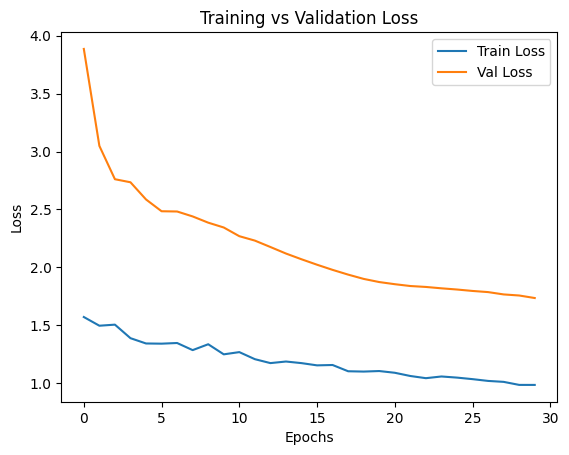

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [18]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 0s - 76ms/step - AUC: 0.3681 - accuracy: 0.0714 - loss: 1.7350
Restored model, accuracy:  7.14%


In [20]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to get binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

print("CNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))

print(classification_report(y_test, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
CNN:
Accuracy: 0.07142857142857142
Precision: 0.24074074074074073
Recall: 0.25925925925925924
F1 Score: 0.1717171717171717
              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         6
        leak       0.22      0.67      0.33         3
       limit       0.50      0.11      0.18         9

   micro avg       0.27      0.17      0.21        18
   macro avg       0.24      0.26      0.17        18
weighted avg       0.29      0.17      0.15        18
 samples avg       0.14      0.10      0.11        18



## CNN With Autoencoder

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

X_unlabeled = np.concatenate([X_train, X_test], axis=0)
# Input
input_layer = Input(shape=(opcode_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(opcode_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_unlabeled, X_unlabeled, epochs=30, batch_size=64)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 6222.2290
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 6217.3511
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 6215.0620
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 6213.7251
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 6212.7720
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 6212.6694
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 6212.3989
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6210.4761
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 6210.2339
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6210.1069
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 6210.0640
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6210.0186
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 6210.0054
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6209.9990
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/

In [22]:
X_encoded = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_train, test_size=0.2, random_state=42)

In [25]:
def EncodedMLClassifier():
    return Sequential([
        Dense(256, input_dim=128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

classifier = EncodedMLClassifier()

classifier.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

model_file = os.path.join(MODEL_PATH, "encoded_cnn_best_model_on_crpwarner.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1944 - loss: 1.1002

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1944 - loss: 1.1002 - val_accuracy: 0.3000 - val_loss: 1.4886 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2222 - loss: 1.0797

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.2222 - loss: 1.0797 - val_accuracy: 0.4000 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3889 - loss: 1.0411 - val_accuracy: 0.3000 - val_loss: 1.3094 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4444 - loss: 1.0045 - val_accuracy: 0.5000 - val_loss: 1.3089 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5000 - loss: 0.9002
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5000 - loss: 0.9002 - val_accuracy: 0.4000 - val_loss: 1.3303 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5278 - loss: 0.8436 - val_accuracy: 0.4000 - val_loss: 1.2918 - learning_rate: 5.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5556 - loss: 0.8795 - val_accuracy: 0.3000 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.4167 - loss: 0.8891 - val_accuracy: 0.3000 - val_loss: 1.2399 - learning_rate: 5.0000e-04
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5000 - loss: 0.8755

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5000 - loss: 0.8755 - val_accuracy: 0.2000 - val_loss: 1.2111 - learning_rate: 5.0000e-04
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5278 - loss: 0.8437

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 0.5278 - loss: 0.8437 - val_accuracy: 0.1000 - val_loss: 1.1935 - learning_rate: 5.0000e-04
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6111 - loss: 0.8757 - val_accuracy: 0.1000 - val_loss: 1.1936 - learning_rate: 5.0000e-04
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5278 - loss: 0.8347

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.5278 - loss: 0.8347 - val_accuracy: 0.2000 - val_loss: 1.1922 - learning_rate: 5.0000e-04
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6667 - loss: 0.7870

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.6667 - loss: 0.7870 - val_accuracy: 0.2000 - val_loss: 1.1856 - learning_rate: 5.0000e-04
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6944 - loss: 0.8063

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.6944 - loss: 0.8063 - val_accuracy: 0.2000 - val_loss: 1.1720 - learning_rate: 5.0000e-04
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5833 - loss: 0.8008

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - accuracy: 0.5833 - loss: 0.8008 - val_accuracy: 0.2000 - val_loss: 1.1643 - learning_rate: 5.0000e-04
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5833 - loss: 0.8172 - val_accuracy: 0.1000 - val_loss: 1.1709 - learning_rate: 5.0000e-04
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4167 - loss: 0.7995 - val_accuracy: 0.1000 - val_loss: 1.1784 - learning_rate: 5.0000e-04
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6111 - loss: 0.7471
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - accuracy: 0.6111 - loss: 0.7471 - val_accuracy: 0.2000 - val_loss: 1.1827 - learning_rate: 5.0000e-04
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.5833 - loss: 0.7740 - val_accuracy: 0.3000 - val_loss: 1.1777 - learning_rate: 2.5000e-04
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5556 - loss: 0.7282 - 

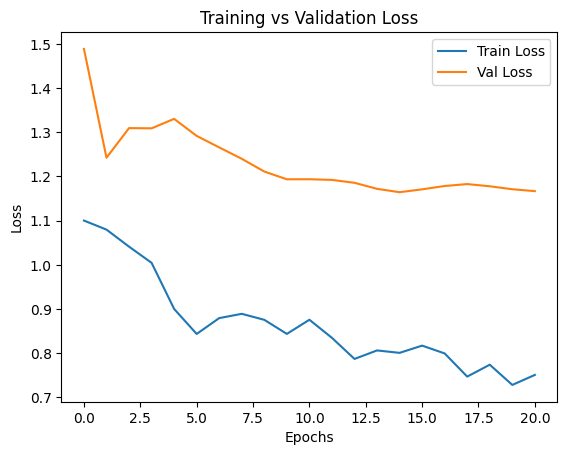

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [27]:
y_pred_prob = classifier.predict(X_val)
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_val, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         2
        leak       0.00      0.00      0.00         2
       limit       0.00      0.00      0.00         5

   micro avg       0.00      0.00      0.00         9
   macro avg       0.00      0.00      0.00         9
weighted avg       0.00      0.00      0.00         9
 samples avg       0.00      0.00      0.00         9

